In [23]:
import os
import chardet
import pandas as pd
import numpy as np
import json
import glob


In [24]:
# instantiating lists for separating grids by day
grids = []
mon_list = []
tue_list = []
wed_list = []
thu_list = []
fri_list = []
sat_list = []
sun_list = []

# creating dict to sort the puzzles by day of the week (dow)
dow_dict={
    "monday":mon_list,
    "tuesday":tue_list,
    "wednesday":wed_list,
    "thursday":thu_list,
    "friday":fri_list,
    "saturday":sat_list,
    "sunday":sun_list
}

# iterating through the directory tree of all the puzzles (this was how the data was stored in the database, unfortunately)
for fpath in glob.glob(pathname="../data/json/*/*/*.json",recursive=True):
    with open(fpath,'r') as cw:
        try:
            cw_json = json.JSONDecoder().decode(cw.readline())
            dow = cw_json['dow'].lower()
            dow_dict[dow] = dow_dict[dow] + [cw_json['grid']]

            # grids = grids + [cw_json['grid']] # get all grids
        except(json.JSONDecodeError):
            print('uh oh')

# raw_grids = grids.copy()




for fpath in glob.glob(pathname="../data/json/*/*/*.json",recursive=True):
    with open(fpath,'r') as cw:
        try:
            cw_json = json.JSONDecoder().decode(cw.readline())
            grids = grids + [cw_json['grid']] # get all grids
        except(json.JSONDecodeError):
            print('uh oh')

raw_grids = grids.copy()


uh oh
uh oh
uh oh
uh oh


In [25]:
# CONSTANTS FOR THE SIZE OF STANDARD SIZE GRIDS (15X15) AS WELL AS THE LARGER SUNDAY GRIDS (21X21)
GRID_DIM = 15
SUNDAY_GRID_DIM = 21

GRID_SHAPE = (GRID_DIM,GRID_DIM)
SUNDAY_GRID_SHAPE = (SUNDAY_GRID_DIM,SUNDAY_GRID_DIM)




In [26]:
#  if a square is empty, 0.  If a square is black, 1.
def bin_gridify(raw_grids):
    binary_grids = []
    for grid in raw_grids:
        new_grid = [1 if x == "." else 0 for x in grid ]
        binary_grids = binary_grids + [new_grid]
    return binary_grids
grids = bin_gridify(raw_grids)

In [27]:
# converting 1d grids to n x n numpy arrays
sunday_grids = [np.array(grid).reshape(SUNDAY_GRID_SHAPE) for grid in grids if len(grid) == SUNDAY_GRID_DIM * SUNDAY_GRID_DIM]
normal_grids = [np.array(grid).reshape(GRID_SHAPE) for grid in grids if len(grid) == GRID_DIM * GRID_DIM]


In [28]:
# summing and normalizing all arrays to generate heatmaps
from sklearn.preprocessing import normalize

normal_grids_sum = np.sum(normal_grids, axis=0)
sunday_grids_sum = np.sum(sunday_grids, axis=0)
normal_grids_sum = normalize(normal_grids_sum)
sunday_grids_sum = normalize(sunday_grids_sum)

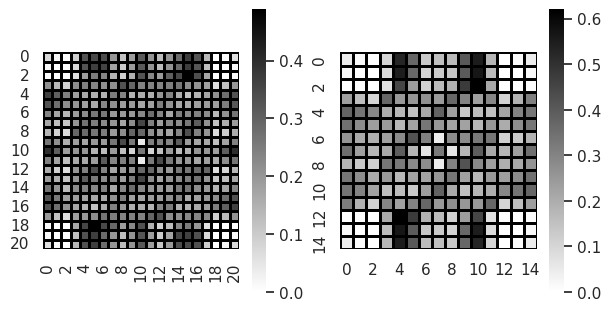

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()




fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,3));
fig.set_constrained_layout(True)
sns.heatmap(normal_grids_sum, ax=ax2,cmap="binary",cbar=True,linewidths=2,linecolor="Black",square=True,);
sns.heatmap(sunday_grids_sum, ax=ax1,cmap="binary",cbar=True,linewidths=2,linecolor="Black",square=True);

In [30]:
import plotly.express as px
from plotly.subplots import make_subplots
fig = make_subplots(1,2)
# px.imshow(normal_grids_sum,c)

In [31]:
across_df = pd.DataFrame([cw_json['clues']['across'],cw_json['answers']['across']])

grid_list_lengths = len(dow_dict['monday']), len(dow_dict['tuesday']),len(dow_dict['wednesday']), len(dow_dict['thursday']), len(dow_dict['friday']), len(dow_dict['saturday']), len(dow_dict['sunday'])
print(grid_list_lengths)
grid_list_lengths = pd.DataFrame(grid_list_lengths,index=dow_dict.keys(),columns=["Number of Puzzles"])
print(grid_list_lengths.T)
fig.add_bar(y=grid_list_lengths['Number of Puzzles'],x=list(grid_list_lengths.index))
# fig.add_bar(x=grid_list_lengths['Number of Puzzles'],y=list(grid_list_lengths.index))

(1168, 1163, 1164, 1150, 1151, 1155, 1154)
                   monday  tuesday  wednesday  thursday  friday  saturday  \
Number of Puzzles    1168     1163       1164      1150    1151      1155   

                   sunday  
Number of Puzzles    1154  


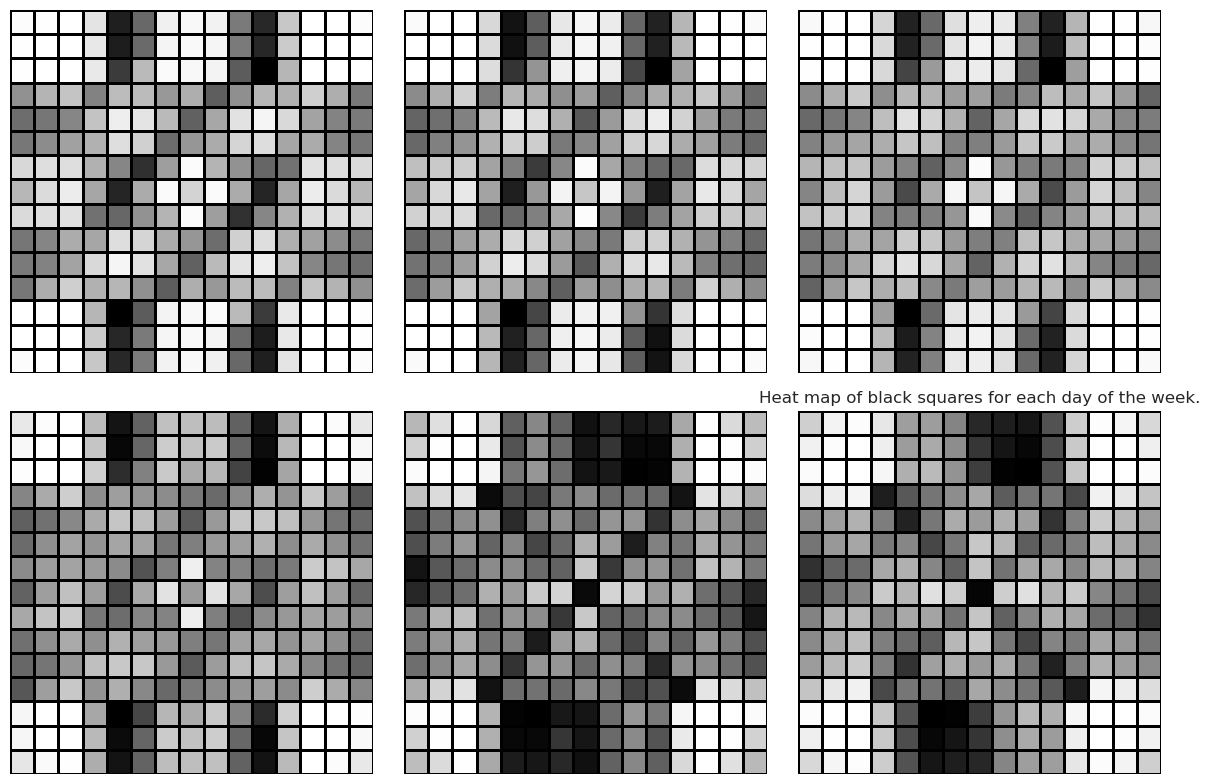

In [32]:

fig, ax_list = plt.subplots(2,3,figsize=(12,8));
dow_plot_dict = {}
# _, ax_list = plt.subplots(3,2);
i = 0
for day in dow_dict.keys():
    grid_list = dow_dict[day]
    grid_list = bin_gridify(grid_list)
    if day != "sunday":
        day_grid = [np.array(grid).reshape(GRID_SHAPE) for grid in grid_list if len(grid) == GRID_DIM * GRID_DIM]
        normalized_grid_sum = normalize(np.sum(day_grid,axis=0))
        idx_tup = (i //3, i%3)
        sns.heatmap(normalized_grid_sum,ax=ax_list[idx_tup],square=True,linewidths=2,linecolor='black',cmap='binary',cbar=False,xticklabels=[None]*GRID_DIM,yticklabels=[None]*GRID_DIM,);
        dow_plot_dict[day] = normalized_grid_sum
        i+=1
    else:
       day_grid = [np.array(grid).reshape(SUNDAY_GRID_SHAPE) for grid in grid_list if len(grid) == SUNDAY_GRID_DIM * SUNDAY_GRID_DIM]


fig.set_tight_layout(True)
plt.title("Heat map of black squares for each day of the week.",loc='center',y=fig.tight_layout())

plt.show()

In [33]:
from jupyter_dash import JupyterDash
import dash
from dash import  dcc, html
from dash.dependencies import Input,Output
import dash_daq as daq
from plotly.subplots import make_subplots
import plotly.express as px


app = JupyterDash(__name__)
# figure = plotly.add_heatmap(colorscale='greys',x=list(range(1,22)),y=list(range(1,22)),dx=1,dy=1,z=sunday_grids_sum)
# figure = px.imshow(sunday_grids_sum,aspect=1)
# figure.add_heatmap(sunday_grids_sum,title="")
px.imshow(sunday_grids_sum,aspect='equal',text_auto=False)
app.layout = html.Div([
    html.H1("Heatmap of Black Boxes in Puzzles, grouped by Day of Week"),
    dcc.Graph(id='graph'),
    html.Label([
        "Day of the Week:",
        dcc.Dropdown(
            id='dow-dd', clearable=False,
            value='sunday', options=[
                {'label': c.capitalize(), 'value': c}
                for c in dow_plot_dict.keys()
            ]),
        daq.BooleanSwitch(
            id="labels-toggle",
            label="Show percentage labels?",
            on=False

        )
    ]),
])

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("dow-dd", "value"),
    Input("labels-toggle",'on')
     ]
)
def update_figure(on,value):
    print(value)
    return px.imshow(dow_plot_dict[value],aspect='equal',text_auto=on)

app.run_server(mode="inline",debug=True)

In [34]:
dow_plot_dict['monday']

array([[0.01015285, 0.00276896, 0.00092299, 0.0729159 , 0.59624904,
        0.40149897, 0.04153438, 0.01938271, 0.03599646, 0.35442668,
        0.57132842, 0.14952375, 0.        , 0.        , 0.00830688],
       [0.00386399, 0.        , 0.        , 0.06182377, 0.6018158 ,
        0.39799055, 0.02994589, 0.01738794, 0.0280139 , 0.35355471,
        0.57380191, 0.13910349, 0.        , 0.        , 0.000966  ],
       [0.00318874, 0.        , 0.        , 0.06058603, 0.52135873,
        0.18494683, 0.01434932, 0.01913243, 0.03348175, 0.43526279,
        0.67920128, 0.19451304, 0.        , 0.        , 0.00159437],
       [0.29449829, 0.20053931, 0.15846813, 0.33376473, 0.17810135,
        0.18230847, 0.27486507, 0.21736779, 0.42912609, 0.29870541,
        0.1963322 , 0.20755118, 0.1290183 , 0.21736779, 0.36040982],
       [0.38922924, 0.36521834, 0.32161961, 0.16112574, 0.04612619,
        0.07203268, 0.18450477, 0.42082252, 0.23379029, 0.07961507,
        0.02906582, 0.10173037, 0.244532  , 

In [35]:
csv = pd.read_csv("../data/clues.bz2", encoding='iso8859_1', compression='bz2',sep="\t",lineterminator='\n',error_bad_lines=False,names=['answer',''])

/tmp/ipykernel_210823/4108787271.py:1: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.





False
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
KeyError: False



b'Skipping line 4781380: expected 2 fields, saw 12\n'


True
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
KeyError: True

False
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
KeyError: False



/tmp/ipykernel_210823/4108787271.py:1: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



True
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
KeyError: True



In [36]:
import bz2
import pandas as pd
import chardet
with bz2.open('../data/clues.bz2',mode="rb",) as f:
    for i in range(0,84797):
        print(chardet.detect(f.readline()))

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confiden

In [37]:
f = pd.read_csv(bz2.open('../data/clues.bz2'),sep='\t')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 84797: invalid continuation byte

In [ ]:
# instantiating lists for different kinds of clues
